In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pptx import Presentation
from pptx.util import Inches, Pt
import os
import io
import matplotlib.ticker as ticker

## OPC data import. Raw file information is: Dp in nm, time is in local time (PST) and the number concentrations are given not divided by the bin size (dlogDp) (check the README file for more info)

In [2]:
# Paths to OPC data files for the 3 different units
path_unit2 = r'C:\Users\GeorgiaRg\Documents\ASCENT\OPC\Data-20260220T185711Z-1-001\OPCdNcc_unit2.csv'
path_unit4 = r'C:\Users\GeorgiaRg\Documents\ASCENT\OPC\Data-20260220T185711Z-1-001\OPCdNcc_unit4.csv'
path_unit8 = r'C:\Users\GeorgiaRg\Documents\ASCENT\OPC\Data-20260220T185711Z-1-001\OPCdNcc_unit8.csv'

# output_folder is the destination folder of all of the plots below
output_dir = r'C:\Users\GeorgiaRg\Documents\ASCENT\OPC\Data-20260220T185711Z-1-001\Output'

In [3]:
df_unit2 = pd.read_csv(path_unit2)
df_unit4 = pd.read_csv(path_unit4)
df_unit8 = pd.read_csv(path_unit8)
df_unit2['local_time_pst'] = pd.to_datetime(df_unit2['local_time_pst'])
df_unit4['local_time_pst'] = pd.to_datetime(df_unit4['local_time_pst'])
df_unit8['local_time_pst'] = pd.to_datetime(df_unit8['local_time_pst'])

## Size distributions calculation (number, volume, mass-change particle density as needed)

In [4]:
# Put the dataframes into a dictionary to loop through them
units_data = {
    'unit2': df_unit2,
    'unit4': df_unit4,
    'unit8': df_unit8
}

# Make sure the output directory exists
os.makedirs(output_dir, exist_ok=True)

for unit_name, df in units_data.items():

    # Extract bin boundaries (Dp) from column headers (300, 350, 400...)
    # We exclude the 'local_time_pst' column
    dp_boundaries = np.array([float(col) for col in df.columns if col != 'local_time_pst'])

    # Since we need an upper bound for the last bin, estimate it
    # by assuming the last step ratio is the same as the second to last.
    last_ratio = dp_boundaries[-1] / dp_boundaries[-2]
    dp_upper = np.append(dp_boundaries[1:], dp_boundaries[-1] * last_ratio)
    dp_lower = dp_boundaries

    # Calculate Bin Constants
    dlogDp = np.log10(dp_upper) - np.log10(dp_lower)
    dp_geo_mean = np.sqrt(dp_lower * dp_upper) # Geometric mean diameter

    # Extract only the concentration data (the grid)
    # Ensure we drop the time column properly
    raw_counts = df.drop(columns=['local_time_pst']).values

    # Calculate Distributions
    # dN/dlogDp
    dn_dlogdp = raw_counts / dlogDp

    # dV/dlogDp (Dp is in nm, converting to um^3/cm^3)
    # Volume of sphere = (pi/6) * D^3.
    # Conversion: (nm^3) * 1e-9 = um^3
    dv_dlogdp = dn_dlogdp * (np.pi / 6) * (dp_geo_mean**3) * 1e-9

    # dM/dlogDp (Density = 1 g/cc = 1 ug/um^3) CHANGE DENSITY HERE IF NEEDED
    dm_dlogdp = dv_dlogdp * 1.0

    # Reconstruct into DataFrames for plotting
    df_dn = pd.DataFrame(dn_dlogdp, columns=df.columns[df.columns != 'local_time_pst'], index=df['local_time_pst'])
    df_dv = pd.DataFrame(dv_dlogdp, columns=df.columns[df.columns != 'local_time_pst'], index=df['local_time_pst'])
    df_dm = pd.DataFrame(dm_dlogdp, columns=df.columns[df.columns != 'local_time_pst'], index=df['local_time_pst'])

Processing data for unit2...
Processing data for unit4...
Processing data for unit8...


## Daily Average number and mass distributions into PP

In [5]:
    # Prep the Data
    df_dn.index = pd.to_datetime(df_dn.index)
    df_dm.index = pd.to_datetime(df_dm.index)

    # Resample to DAILY Averages
    daily_dn = df_dn.resample('D').mean().dropna(how='all')
    daily_dm = df_dm.resample('D').mean().dropna(how='all')

    # Initialize the PowerPoint Presentation
    prs = Presentation()
    blank_slide_layout = prs.slide_layouts[6]

    # Plotting Loop & PowerPoint Generation
    for day in daily_dn.index:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10), sharex=True)
        day_str = day.strftime('%Y-%m-%d')

        # --- Upper Plot: Number Distribution ---
        ax1.plot(dp_geo_mean[:-1], daily_dn.loc[day].iloc[:-1], color='blue', lw=2, marker='o', markersize=4)
        ax1.set_ylabel(r'$dN/d\log D_p$ (#/cm$^3$)', fontsize=12)
        ax1.set_title(f'[{unit_name.upper()}] Daily Aerosol Size Distribution: {day_str}', fontsize=14, fontweight='bold')
        ax1.grid(True, which="both", ls="-", alpha=0.3)

        # --- Lower Plot: Mass Distribution ---
        ax2.plot(dp_geo_mean[:-1], daily_dm.loc[day].iloc[:-1], color='red', lw=2, marker='s', markersize=4)
        ax2.set_ylabel(r'$dM/d\log D_p$ ($\mu$g/m$^3$)', fontsize=12)
        ax2.set_xlabel('Particle Diameter $D_p$ (nm)', fontsize=12)
        ax2.grid(True, which="both", ls="-", alpha=0.3)

        # --- Customizing the Logarithmic X-Axis Ticks ---
        ax2.set_xscale('log')
        ax2.xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0, 2.0, 3.0, 4.0, 5.0, 7.0)))
        formatter = ticker.ScalarFormatter()
        formatter.set_scientific(False)
        ax2.xaxis.set_major_formatter(formatter)

        plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
        plt.tight_layout()

        # Save the figure to an in-memory buffer
        image_stream = io.BytesIO()
        plt.savefig(image_stream, format='png', dpi=300)
        plt.close(fig)
        image_stream.seek(0)

        # --- Add to PowerPoint ---
        slide = prs.slides.add_slide(blank_slide_layout)
        left = Inches(1.5)
        top = Inches(0)
        height = Inches(7.5)
        slide.shapes.add_picture(image_stream, left, top, height=height)

    # Save the Presentation specifically for this unit
    ppt_filename = os.path.join(output_dir, f"Daily_Distributions_Presentation_{unit_name}.pptx")
    prs.save(ppt_filename)

    print(f"Presentation for {unit_name} generated successfully. Saved to: {ppt_filename}\n")

Presentation for unit8 generated successfully. Saved to: C:\Users\GeorgiaRg\Documents\ASCENT\OPC\Data-20260220T185711Z-1-001\Output\Daily_Distributions_Presentation_unit8.pptx



## Hourly Timeseries PM1, PM2.5, PM10

Calculating mass, cleaning missing data, and resampling to hourly averages...
Generating Timeseries plot...


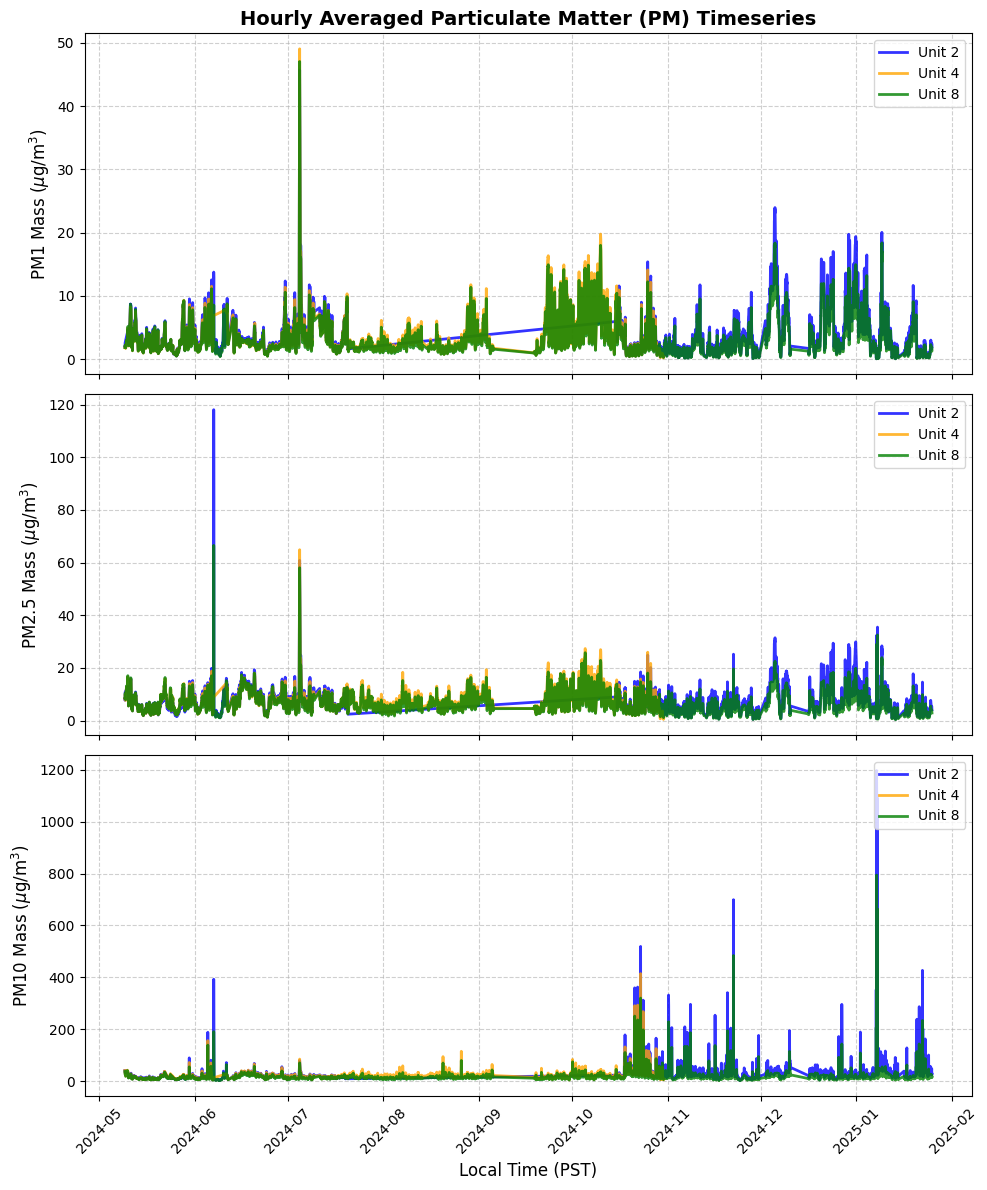

In [10]:
# Put the dataframes into a dictionary for easy iteration
units_data = {
    'Unit 2': df_unit2,
    'Unit 4': df_unit4,
    'Unit 8': df_unit8
}

# Dictionaries to store the hourly averaged PM timeseries
pm1_hourly = {}
pm25_hourly = {}
pm10_hourly = {}

for unit_name, df in units_data.items():
    if 'local_time_pst' in df.columns:
        df_temp = df.set_index('local_time_pst')
    else:
        df_temp = df.copy()

    df_temp.index = pd.to_datetime(df_temp.index)

    # Extract bin boundaries (Dp)
    dp_boundaries = np.array([float(col) for col in df_temp.columns])

    last_ratio = dp_boundaries[-1] / dp_boundaries[-2]
    dp_upper = np.append(dp_boundaries[1:], dp_boundaries[-1] * last_ratio)
    dp_lower = dp_boundaries
    dp_geo_mean = np.sqrt(dp_lower * dp_upper)

    # Raw counts (dN) for each bin
    raw_counts = df_temp.values

    # Calculate dM for each bin
    dM = raw_counts * (np.pi / 6) * (dp_geo_mean**3) * 1e-9 * 1.0
    df_dM = pd.DataFrame(dM, columns=dp_boundaries, index=df_temp.index)

    # Masks for PM1, PM2.5, PM10
    mask_pm1 = dp_upper <= 1000
    mask_pm25 = dp_upper <= 2500
    mask_pm10 = dp_upper <= 10000

    # Calculate raw sums for each timestep
    # We replace 0 with np.nan here so that missing data doesn't artificially lower the hourly mean.
    pm1_raw = df_dM.loc[:, mask_pm1].sum(axis=1).replace(0, np.nan)
    pm25_raw = df_dM.loc[:, mask_pm25].sum(axis=1).replace(0, np.nan)
    pm10_raw = df_dM.loc[:, mask_pm10].sum(axis=1).replace(0, np.nan)

    # Resample to HOURLY averages ('h' stands for hourly). NaNs are automatically ignored.
    pm1_hourly[unit_name] = pm1_raw.resample('h').mean().dropna()
    pm25_hourly[unit_name] = pm25_raw.resample('h').mean().dropna()
    pm10_hourly[unit_name] = pm10_raw.resample('h').mean().dropna()


# =========================================================
# 3-Panel Plotting (Hourly Timeseries)
# =========================================================

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
colors = {'Unit 2': 'blue', 'Unit 4': 'orange', 'Unit 8': 'green'}

for unit_name in units_data.keys():
    ax1.plot(pm1_hourly[unit_name].index, pm1_hourly[unit_name], label=unit_name, color=colors[unit_name], alpha=0.8, linewidth=2)
    ax2.plot(pm25_hourly[unit_name].index, pm25_hourly[unit_name], label=unit_name, color=colors[unit_name], alpha=0.8, linewidth=2)
    ax3.plot(pm10_hourly[unit_name].index, pm10_hourly[unit_name], label=unit_name, color=colors[unit_name], alpha=0.8, linewidth=2)

# Format Top Panel
ax1.set_ylabel(r'PM1 Mass ($\mu$g/m$^3$)', fontsize=12)
ax1.set_title('Hourly Averaged Particulate Matter (PM) Timeseries', fontsize=14, fontweight='bold')
ax1.legend(loc='upper right')
ax1.grid(True, linestyle='--', alpha=0.6)

# Format Middle Panel
ax2.set_ylabel(r'PM2.5 Mass ($\mu$g/m$^3$)', fontsize=12)
ax2.legend(loc='upper right')
ax2.grid(True, linestyle='--', alpha=0.6)

# Format Bottom Panel
ax3.set_ylabel(r'PM10 Mass ($\mu$g/m$^3$)', fontsize=12)
ax3.set_xlabel('Local Time (PST)', fontsize=12)
ax3.legend(loc='upper right')
ax3.grid(True, linestyle='--', alpha=0.6)

plt.xticks(rotation=45)
plt.tight_layout()

# Save the timeseries plot
ts_plot_path = os.path.join(output_dir, 'PM1_PM25_PM10_Hourly_Timeseries.png')
plt.savefig(ts_plot_path, dpi=300)
plt.show()

## Scatter plots between OPC units for hourly PM1, PM2.5, PM10

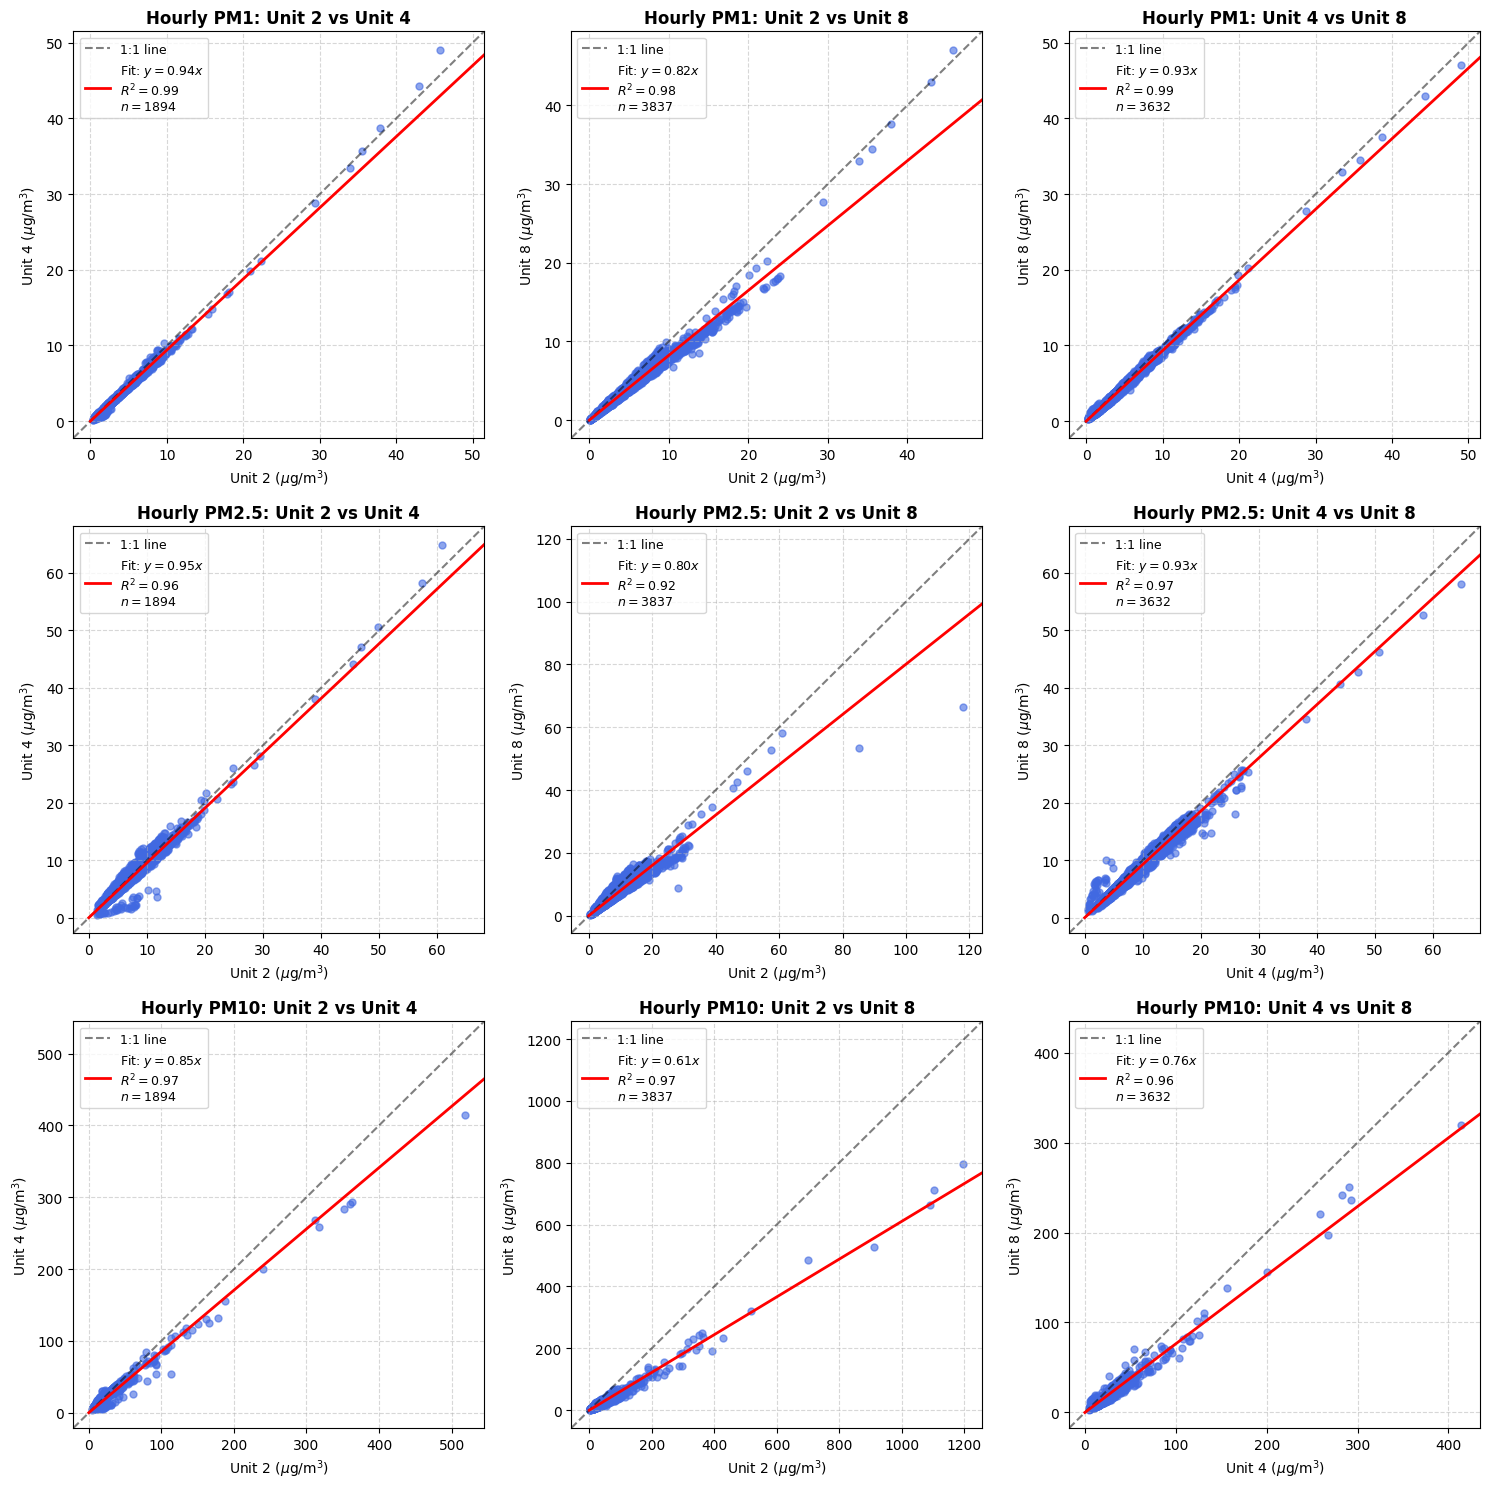

In [15]:
comparisons = [('Unit 2', 'Unit 4'), ('Unit 2', 'Unit 8'), ('Unit 4', 'Unit 8')]
pm_metrics_hourly = [
    ('PM1', pm1_hourly),
    ('PM2.5', pm25_hourly),
    ('PM10', pm10_hourly)
]

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for row_idx, (pm_label, pm_dict) in enumerate(pm_metrics_hourly):
    for col_idx, (unit_x, unit_y) in enumerate(comparisons):
        ax = axes[row_idx, col_idx]

        series_x = pm_dict[unit_x]
        series_y = pm_dict[unit_y]

        # Combine them to ensure timestamps strictly align
        df_compare = pd.concat([series_x, series_y], axis=1, join='inner').dropna()
        df_compare.columns = [unit_x, unit_y]

        # STRICT FILTER: Keep only rows where BOTH units have mass > 0
        df_compare = df_compare[(df_compare[unit_x] > 0) & (df_compare[unit_y] > 0)]

        # Scatter plot
        ax.scatter(df_compare[unit_x], df_compare[unit_y], alpha=0.6, s=25, color='royalblue')

        if not df_compare.empty:
            # Extract x and y as numpy arrays for math
            x_vals = df_compare[unit_x].values
            y_vals = df_compare[unit_y].values

            # Count the number of valid overlapping data points
            n_points = len(x_vals)

            # Calculate the best fit line y = a*x
            a = np.sum(x_vals * y_vals) / np.sum(x_vals**2)

            # Calculate R^2
            y_pred = a * x_vals
            ss_res = np.sum((y_vals - y_pred)**2)
            ss_tot = np.sum((y_vals - np.mean(y_vals))**2)
            r_squared = 1 - (ss_res / ss_tot)

            # Determine plot limits to keep it square
            min_val = min(x_vals.min(), y_vals.min())
            max_val = max(x_vals.max(), y_vals.max())

            # Add Padding
            padding = (max_val - min_val) * 0.05
            if padding == 0: padding = 1.0 # fallback if min equals max
            min_lim = min_val - padding
            max_lim = max_val + padding

            ax.set_xlim(min_lim, max_lim)
            ax.set_ylim(min_lim, max_lim)

            # Plot the 1:1 reference line
            ax.plot([min_lim, max_lim], [min_lim, max_lim], 'k--', alpha=0.5, label='1:1 line')

            # Plot the y = a*x best-fit line, now adding n_points to the legend
            line_x = np.array([0, max_lim])
            line_y = a * line_x

            # The label string below incorporates the equation, R^2, and n
            legend_label = (rf'Fit: $y = {a:.2f}x$' + '\n' +
                            rf'$R^2 = {r_squared:.2f}$' + '\n' +
                            rf'$n = {n_points}$')

            ax.plot(line_x, line_y, color='red', linestyle='-', linewidth=2, label=legend_label)

        ax.set_title(rf'Hourly {pm_label}: {unit_x} vs {unit_y}', fontsize=12, fontweight='bold')
        ax.set_xlabel(rf'{unit_x} ($\mu$g/m$^3$)', fontsize=10)
        ax.set_ylabel(rf'{unit_y} ($\mu$g/m$^3$)', fontsize=10)
        ax.grid(True, linestyle='--', alpha=0.5)

        # Enable the legend on ALL subplots
        ax.legend(loc='upper left', fontsize=9)

plt.tight_layout()

# Save the scatter plot
scatter_plot_path = os.path.join(output_dir, 'Scatter_Plots_Hourly_Comparison_with_Fit.png')
plt.savefig(scatter_plot_path, dpi=300)
plt.show()